In [1]:
ls /Users/Kunal/Downloads/ | grep taxi

nyc-taxi-trip-duration/
nyc-taxi-trip-duration.zip


In [2]:
import pandas as pd 
train_df = pd.read_csv('~/Downloads/nyc-taxi-trip-duration/train.csv')

In [4]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [10]:
import numpy as np
import math
@np.vectorize
def haversine(lat1, lon1, lat2, lon2): 
	
	# distance between latitudes 
	# and longitudes 
	dLat = (lat2 - lat1) * math.pi / 180.0
	dLon = (lon2 - lon1) * math.pi / 180.0

	# convert to radians 
	lat1 = (lat1) * math.pi / 180.0
	lat2 = (lat2) * math.pi / 180.0

	# apply formulae 
	a = (pow(math.sin(dLat / 2), 2) +
		pow(math.sin(dLon / 2), 2) *
			math.cos(lat1) * math.cos(lat2)); 
	rad = 6371 #earths radius
	c = 2 * math.asin(math.sqrt(a)) 
	return rad * c 




In [11]:
train_df['distance_in_km' ] = haversine(train_df['pickup_latitude'], train_df['pickup_longitude'],
                                           train_df['dropoff_latitude'], train_df['dropoff_longitude'])

In [19]:
train_df.corr()['trip_duration'].sort_values(ascending=False)

trip_duration        1.000000
distance_in_km       0.094777
pickup_longitude     0.026542
vendor_id            0.020304
dropoff_longitude    0.014678
passenger_count      0.008471
dropoff_latitude    -0.020677
pickup_latitude     -0.029204
Name: trip_duration, dtype: float64

In [20]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_in_km'],
      dtype='object')

In [21]:
train_df['store_and_fwd_flag'].unique()

array(['N', 'Y'], dtype=object)

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

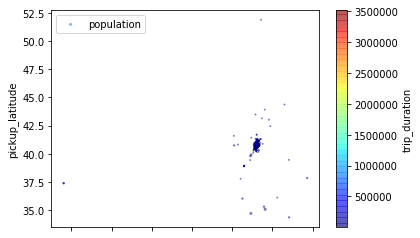

In [23]:
train_df.plot(kind='scatter',x = 'pickup_longitude' , y= 'pickup_latitude' , alpha =0.4,
             s = train_df['passenger_count'], label='population', c = 'trip_duration' , cmap = plt.get_cmap("jet"),colorbar=True
            )
plt.legend()

In [26]:
from sklearn.metrics import mean_squared_log_error

In [27]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_in_km'],
      dtype='object')

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

In [69]:
class NumAttributePicker(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X,y=None):
        X['distance_in_km' ] = haversine(X['pickup_latitude'], X['pickup_longitude'],
                                           X['dropoff_latitude'], X['dropoff_longitude'])
        
        
        X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])

        X['week_day' ] = X['pickup_datetime'].dt.weekday

        X['month' ] = X['pickup_datetime'].dt.month

        X['month_day' ] =X['pickup_datetime'].dt.day

        X['hour' ] = X['pickup_datetime'].dt.hour

        X['minute' ] = X['pickup_datetime'].dt.minute

        X['minutes'] = X['hour'] * 60 + X['minute']
        
        needed_cols= [ 'distance_in_km' ,'week_day' , 'month' , 'month_day', 'minutes' ]
        return X[needed_cols].values

In [65]:
from sklearn.preprocessing import LabelBinarizer , LabelEncoder
class MyLabelBinarizer(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.one_hot_encoder = OneHotEncoder()
        
    def fit(self, X, y=None ):
        
        label_encoded_x = self.label_encoder.fit_transform(X)
        self.one_hot_encoder.fit(label_encoded_x.reshape(-1,1))
        return self
    
    def transform(self,X):
        label_encoded_x = self.label_encoder.transform(X)
        return self.one_hot_encoder.transform(label_encoded_x.reshape(-1,1)).toarray()
    
class CatAttribPicker(BaseEstimator, TransformerMixin):
        
    def __init__(self):
        self.needed_cols = ['vendor_id' , 'store_and_fwd_flag']
        self.label_binarizers = {}
        for col in self.needed_cols:
            self.label_binarizers[col] = MyLabelBinarizer()
    
    def fit(self, X, y=None):
        X=X[self.needed_cols]
        
        for col in self.needed_cols:
            self.label_binarizers[col].fit(X[col])
            
        return self
    
    def transform(self, X, y=None):
        X=X[['vendor_id' , 'store_and_fwd_flag']]
        
        vendors =self.label_binarizers['vendor_id'].transform(X['vendor_id'])
        sff =self.label_binarizers['store_and_fwd_flag'].transform(X['store_and_fwd_flag'])
        return np.c_[vendors,sff]

In [35]:
train_df_reduced = NumAttributePicker().fit_transform(train_df)

In [36]:
train_df_reduced.head()

,vendor_id,pickup_datetime,distance_in_km,store_and_fwd_flag
0,2,2016-03-14 17:24:55,1.498521,N
1,1,2016-06-12 00:43:35,1.805507,N
2,2,2016-01-19 11:35:24,6.385098,N
3,2,2016-04-06 19:32:31,1.485498,N
4,2,2016-03-26 13:30:55,1.188588,N


In [38]:
train_df_reduced['pickup_datetime'].max(), train_df_reduced['pickup_datetime'].min()

('2016-06-30 23:59:39', '2016-01-01 00:00:17')

In [48]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])

train_df['week_day' ] = train_df['pickup_datetime'].dt.weekday

train_df['month' ] = train_df['pickup_datetime'].dt.month

train_df['month_day' ] =train_df['pickup_datetime'].dt.day

train_df['hour' ] = train_df['pickup_datetime'].dt.hour

train_df['minute' ] = train_df['pickup_datetime'].dt.minute

train_df['minutes'] = train_df['hour'] * 60 + train_df['minute']

In [55]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_in_km,week_day,month,month_day,hour,minute,minutes
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498521,0,3,14,17,24,1044
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805507,6,6,12,0,43,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385098,1,1,19,11,35,695
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485498,2,4,6,19,32,1172
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188588,5,3,26,13,30,810


In [66]:
cat_picker = CatAttribPicker()
transformed = cat_picker.fit_transform(train_df)

In [70]:
num_picker = NumAttributePicker()
num_transformed = num_picker.fit_transform(train_df)

In [71]:
num_transformed

array([[1.49852078e+00, 0.00000000e+00, 3.00000000e+00, 1.40000000e+01,
        1.04400000e+03],
       [1.80550717e+00, 6.00000000e+00, 6.00000000e+00, 1.20000000e+01,
        4.30000000e+01],
       [6.38509850e+00, 1.00000000e+00, 1.00000000e+00, 1.90000000e+01,
        6.95000000e+02],
       ...,
       [7.82460578e+00, 4.00000000e+00, 4.00000000e+00, 2.20000000e+01,
        4.17000000e+02],
       [1.09256389e+00, 1.00000000e+00, 1.00000000e+00, 5.00000000e+00,
        9.56000000e+02],
       [1.13404196e+00, 1.00000000e+00, 4.00000000e+00, 5.00000000e+00,
        8.84000000e+02]])

In [72]:
from sklearn.pipeline import FeatureUnion
preparatory_pipeline = FeatureUnion([
    ('num_pipeline' , NumAttributePicker()),
    ('cat_pipeline' , CatAttribPicker())
])

In [75]:
X = preparatory_pipeline.fit_transform(train_df)
y = train_df['trip_duration']

In [78]:
from sklearn.model_selection import cross_val_score

In [79]:
from sklearn.linear_model import LinearRegression

In [81]:
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X, y, cv = 2 , scoring='neg_mean_squared_log_error')

In [83]:
msle = -scores

In [85]:
rmsle = np.sqrt(msle)

rmsle

In [87]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
scores = cross_val_score(forest_reg, X, y, cv=2, scoring='neg_mean_squared_log_error')

In [88]:
scores

array([-0.37325369, -0.37419002])

In [89]:
msle = -scores
rmsle = np.sqrt(msle)
rmsle

array([0.61094491, 0.61171073])

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [91]:
X

array([[-0.45207182, -1.5610618 , -0.30743981, ...,  0.9323801 ,
         0.07447137, -0.07447137],
       [-0.38062209,  1.50950205,  1.47717297, ..., -1.07252397,
         0.07447137, -0.07447137],
       [ 0.68525766, -1.04930116, -1.49718167, ...,  0.9323801 ,
         0.07447137, -0.07447137],
       ...,
       [ 1.02029665,  0.48598077,  0.28743112, ...,  0.9323801 ,
         0.07447137, -0.07447137],
       [-0.54655651, -1.04930116, -1.49718167, ..., -1.07252397,
         0.07447137, -0.07447137],
       [-0.53690267, -1.04930116,  0.28743112, ..., -1.07252397,
         0.07447137, -0.07447137]])

In [92]:
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X, y, cv = 2 , scoring='neg_mean_squared_log_error')

In [93]:
scores

array([-0.47074324, -0.4762525 ])

In [94]:
msle = -scores
rmsle = np.sqrt(msle)
rmsle

array([0.68610731, 0.6901105 ])

In [95]:
full_pipeline = Pipeline([
    ('preparator' , preparatory_pipeline),
    ('scaler' , StandardScaler()),
    ('predictor', LinearRegression())
])

In [99]:

full_pipeline.fit(train_df, train_df['trip_duration'])

Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [100]:
test_df = pd.read_csv('/Users/Kunal/Downloads/nyc-taxi-trip-duration/test.csv')

In [102]:
preds = full_pipeline.predict(test_df)

In [104]:
test_df['trip_duration'] = preds

In [106]:
test_df[['id', 'trip_duration' ] ].to_csv('nyc_basic_submission.csv' , index=False)

In [111]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor()
scores = cross_val_score(sgd_reg, X, y, scoring='neg_mean_squared_log_error', cv=3)

np.sqrt(-scores)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/Kunal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/Kunal/anaco

array([0.68118743, 0.64186796, 0.63788859])

In [113]:
lin_reg


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [136]:
class VotingRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, estimators):
        self.estimators = {}
        self.estimators = estimators


    
    def fit(self, X, y=None):
        for key,estimator in self.estimators:
            estimator.fit(X,y)
            
    def predict(self, X):
        scores = np.zeros(len(X))
        
        for key, estimator in self.estimators:
            preds = estimator.predict(X)
            scores = scores + preds
            
        scores = scores/ len(self.estimators)

In [122]:
sgd_reg.fit(X,y)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [123]:
np.zeros(len(X)) + sgd_reg.predict(X)

array([ 702.14022602,  713.94970161, 1188.86668636, ..., 1529.60089433,
        438.17906918,  601.62783554])

In [124]:
len({'a' : 1 , 'b' : 3})

2

In [137]:
lin_reg_predictor = Pipeline([
    ('preparator' , preparatory_pipeline),
    ('scaler' , StandardScaler()),
    ('predictor', LinearRegression())
])
sgd_reg_predictor = Pipeline([
    ('preparator' , preparatory_pipeline),
    ('scaler' , StandardScaler()),
    ('predictor', SGDRegressor())
])

forest_reg_predictor = Pipeline([
    ('preparator' , preparatory_pipeline),
    ('scaler' , StandardScaler()),
    ('predictor', RandomForestRegressor())
])



In [140]:
voting_reg = VotingRegressor([
    ('lin_reg', lin_reg_predictor),
    ('sgd_reg', sgd_reg_predictor)
])

In [141]:
cross_val_score(voting_reg, train_df, train_df['trip_duration'] , cv=2 , scoring='neg_mean_squared_log_error')

/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [142]:
sgd_reg_predictor.fit(train_df, train_df['trip_duration'])

/Users/Kunal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', SGDRegressor(alpha=0.0001, averag...      power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['trip_duration'])

In [145]:
sgd_reg_predictor.fit(X_train, y_train)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', SGDRegressor(alpha=0.0001, averag...      power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

In [146]:
sgd_reg_preds = sgd_reg_predictor.predict(X_test)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [147]:
lin_reg_predictor.fit(X_train, y_train)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [148]:
lin_reg_preds = lin_reg_predictor.predict(X_test)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [151]:
final_preds = sgd_reg_preds + lin_reg_preds

In [153]:
final_preds = final_preds / 2

In [154]:
final_preds

array([1196.87205927, 1992.85358214, 1183.52480658, ...,  910.94482368,
       1099.96065384, 1757.86430439])

In [155]:
from sklearn.metrics import mean_squared_log_error

In [156]:
msle = mean_squared_log_error(y_test, final_preds)

In [158]:
msle


0.5194933160372645

In [169]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, final_preds)

482.71335803613243

In [164]:
final_preds1 = ( sgd_reg_preds + lin_reg_preds) / 2

In [166]:
final_preds1 == final_preds

array([ True,  True,  True, ...,  True,  True,  True])

In [170]:
y_test.describe()

count    364661.000000
mean        955.411253
std        3219.103137
min           1.000000
25%         396.000000
50%         661.000000
75%        1074.000000
max       86392.000000
Name: trip_duration, dtype: float64

In [174]:
train_df[train_df['store_and_fwd_flag'] == 'N'].describe()['trip_duration'].apply(lambda x : round(x, 3))

count    1450599.000
mean         958.820
std         5251.475
min            1.000
25%          397.000
50%          662.000
75%         1074.000
max      3526282.000
Name: trip_duration, dtype: float64

In [175]:
train_df[train_df['store_and_fwd_flag'] == 'Y'].describe()['trip_duration'].apply(lambda x : round(x, 3))

count    8045.000
mean     1080.763
std       925.645
min         2.000
25%       455.000
50%       812.000
75%      1400.000
max      9984.000
Name: trip_duration, dtype: float64

In [176]:
train_df[train_df['trip_duration'] == 3526282 ]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_in_km,week_day,month,month_day,hour,minute,minutes
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,19.900661,5,2,13,22,46,1366


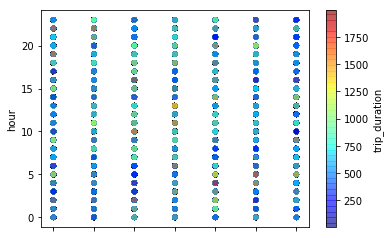

In [191]:
train_df[train_df['trip_duration'] < 2000 ].plot(kind='scatter', x='week_day', y='hour', c= 'trip_duration',  cmap = plt.cm.jet, alpha=0.4)

In [188]:
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance_in_km,week_day,month,month_day,hour,minute,minutes
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.440864e+00,3.050375e+00,3.516818e+00,1.550402e+01,1.360648e+01,2.959016e+01,8.459792e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,4.296538e+00,1.954039e+00,1.681038e+00,8.703135e+00,6.399693e+00,1.732471e+01,3.843181e+02
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,1.231837e+00,1.000000e+00,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,5.730000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,2.093717e+00,3.000000e+00,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,8.860000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,3.875337e+00,5.000000e+00,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,1.168000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,1.240909e+03,6.000000e+00,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.439000e+03


In [189]:
train_df.describe()['trip_duration'].apply(lambda x : round(x, 3))

count    1458644.000
mean         959.492
std         5237.432
min            1.000
25%          397.000
50%          662.000
75%         1075.000
max      3526282.000
Name: trip_duration, dtype: float64

In [203]:
from sklearn.model_selection import GridSearchCV
lin_params = {'predictor__normalize' : [True, False] }
grid_search = GridSearchCV(lin_reg_predictor, lin_params , n_jobs = -1 , cv =3 , verbose= 2,
                          scoring = 'neg_mean_squared_log_error')

In [204]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] predictor__normalize=True .......................................
[CV] predictor__normalize=True .......................................


/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

[CV] predictor__normalize=True .......................................


/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

[CV] predictor__normalize=False ......................................


/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

[CV] ........................ predictor__normalize=True, total=  15.3s
[CV] predictor__normalize=False ......................................
[CV] ........................ predictor__normalize=True, total=  17.3s
[CV] predictor__normalize=False ......................................
[CV] ........................ predictor__normalize=True, total=  18.6s


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   33.9s remaining:   33.9s
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

[CV] ....................... predictor__normalize=False, total=  17.0s


/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

[CV] ....................... predictor__normalize=False, total=  11.7s
[CV] ....................... predictor__normalize=False, total=   9.7s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   46.1s finished
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'predictor__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=2)

In [205]:
grid_search.best_params_

{'predictor__normalize': True}

In [206]:
preds = grid_search.best_estimator_.predict(X_test)

/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/Kunal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [202]:
np.sqrt(mean_squared_log_error(y_test, preds))

0.687582926562508

In [207]:
np.sqrt(mean_squared_log_error(y_test, preds))

0.687582926562508

In [219]:
forest_clf_params = { 'predictor__max_depth' : [6 , 8 , 10 ],
                    'predictor__n_estimators' : [100 , 200 , 300 ],
                    'predictor__min_samples_split' : [ 1000 , 10000]}

In [220]:
import warnings
warnings.simplefilter('ignore')

In [221]:
forest_grid_search = GridSearchCV( forest_reg_predictor , forest_clf_params, cv =2 , n_jobs=-1 , verbose = 2,
                                       scoring = 'neg_mean_squared_log_error')



In [222]:
forest_grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=200 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=200 
[CV]  predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100, total= 5.1min
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=300 
[CV]  predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100, total= 5.1min
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=300 
[CV]  predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=200, total= 9.7min
[CV] predictor__max_depth=6, predictor__min_samples_split

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 102.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', RandomForestRegressor(bootstrap=T...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'predictor__max_depth': [6, 8, 10], 'predictor__n_estimators': [100, 200, 300], 'predictor__min_samples_split': [1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=2)

In [223]:
forest_grid_search.best_params_

{'predictor__max_depth': 10,
 'predictor__min_samples_split': 1000,
 'predictor__n_estimators': 300}

In [224]:
preds = forest_grid_search.best_estimator_.predict(X_test)

In [225]:
np.sqrt(mean_squared_log_error(y_test, preds))

0.5814519255593479

In [226]:
test_df = pd.read_csv('/Users/Kunal/Downloads/nyc-taxi-trip-duration/test.csv')

In [227]:
X_train.shape

(1093983, 18)

In [228]:
X_test.shape

(364661, 18)

In [229]:
forest_reg = RandomForestRegressor(max_depth=10, min_samples_split=1000, n_estimators=300)

In [231]:
forest_reg_predictor


Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', RandomForestRegressor(bootstrap=T...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [234]:
forest_reg = RandomForestRegressor(max_depth=10, min_samples_split=1000, n_estimators=300, n_jobs=-1)

In [235]:
best_forest_reg_predictor = Pipeline([
    ('preparator' , preparatory_pipeline),
    ('scaler' , StandardScaler()),
    ('predictor', forest_reg )
])

In [236]:
best_forest_reg_predictor.fit(train_df, train_df['trip_duration'])

Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', RandomForestRegressor(bootstrap=T...mators=300, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [237]:
preds = best_forest_reg_predictor.predict(X_test)

In [238]:
np.sqrt(mean_squared_log_error(y_test, preds))

0.57442885464107

In [239]:
test_df = pd.read_csv('/Users/Kunal/Downloads/nyc-taxi-trip-duration/test.csv')

In [240]:
test_preds = best_forest_reg_predictor.predict(test_df)

In [242]:
test_df['trip_duration' ] = test_preds

In [244]:
test_df[['id', 'trip_duration'] ].to_csv('nyc_grid_search_forest_reg_sol.csv' , index=False)

In [245]:
ls  | grep nyc_grid_search_forest_reg_sol

nyc_grid_search_forest_reg_sol.csv


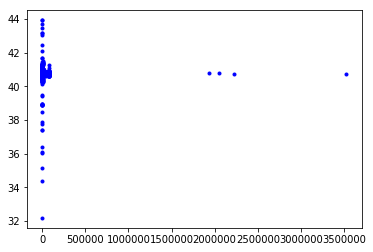

In [247]:
plt.plot(train_df['trip_duration'] , train_df['dropoff_latitude' ] ,'b.')

In [251]:
train_df['passenger_count'].describe().apply(lambda x : round(x, 3))

count    1458644.000
mean           1.665
std            1.314
min            0.000
25%            1.000
50%            1.000
75%            2.000
max            9.000
Name: passenger_count, dtype: float64

In [288]:
def plot_comparison_with_attr(attr_name):
    plot_df = pd.pivot_table(train_df , index = attr_name , values = 'trip_duration' , aggfunc = 'mean').reset_index()
    plt.plot(plot_df[attr_name] , plot_df['trip_duration'] )
    plt.xlabel(attr_name)
    plt.ylabel('trip_duration')

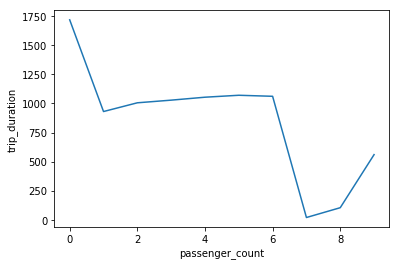

In [289]:
plot_comparison_with_attr('passenger_count')

In [261]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_in_km', 'week_day', 'month', 'month_day',
       'hour', 'minute', 'minutes'],
      dtype='object')

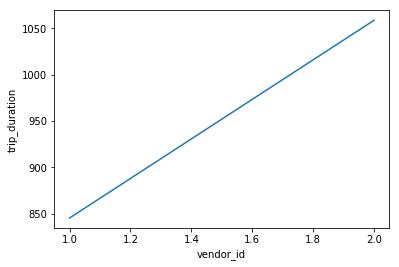

In [290]:
plot_comparison_with_attr('vendor_id')

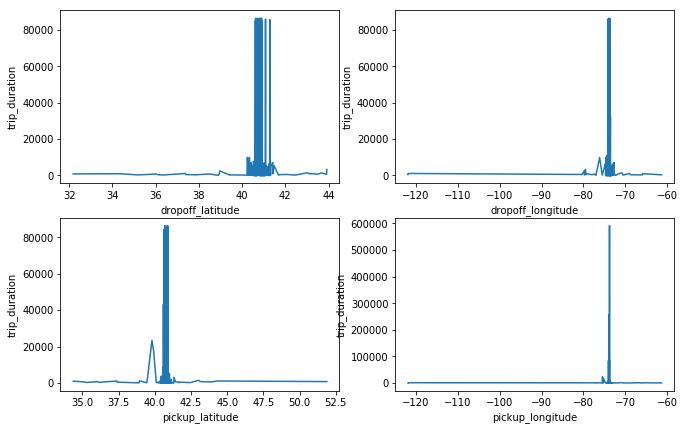

In [291]:
plt.figure(figsize=(11,7))
plt.subplot(221)
plot_comparison_with_attr('dropoff_latitude')
plt.subplot(222)
plot_comparison_with_attr('dropoff_longitude')
plt.subplot(223)
plot_comparison_with_attr('pickup_latitude')
plt.subplot(224)
plot_comparison_with_attr('pickup_longitude')

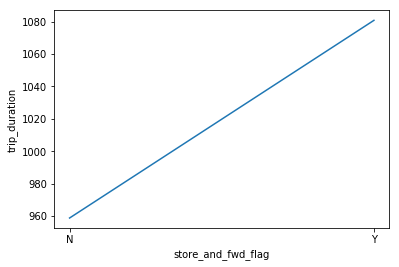

In [292]:
plot_comparison_with_attr('store_and_fwd_flag')

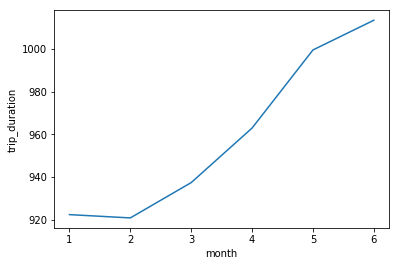

In [293]:
plot_comparison_with_attr('month')

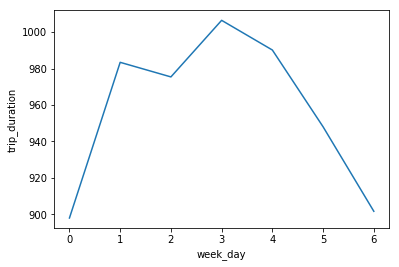

In [294]:
plot_comparison_with_attr('week_day')

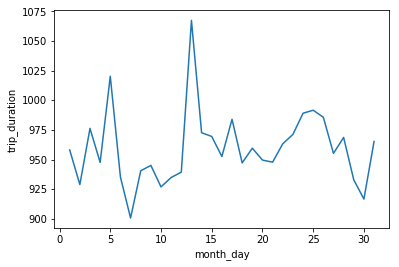

In [295]:
plot_comparison_with_attr('month_day')

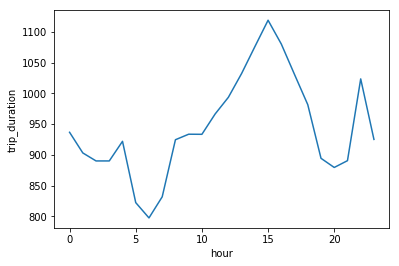

In [296]:
plot_comparison_with_attr('hour')

##### As we can see looks like around in the afternoon trip duration really seems to peek. and in the case of the weekday it is clear that in the middle of the week people generally do longer trips

In [297]:
train_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_in_km', 'week_day', 'month', 'month_day',
       'hour', 'minute', 'minutes'],
      dtype='object')

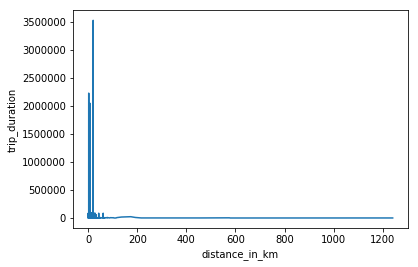

In [298]:
plot_comparison_with_attr('distance_in_km')

In [322]:
dist_data = train_df['distance_in_km'].value_counts().reset_index().sort_values('index')


In [323]:
import math
dist_data['dist_bin'] = dist_data['index'].apply(lambda x : int(math.ceil(x) / 5))


In [324]:
dist_X  =pd.pivot_table(dist_data, index='dist_bin', values='distance_in_km' , aggfunc='sum').reset_index()

In [325]:
dist_X.head()

,dist_bin,distance_in_km
0,0,1107983
1,1,236722
2,2,63360
3,3,19651
4,4,29197


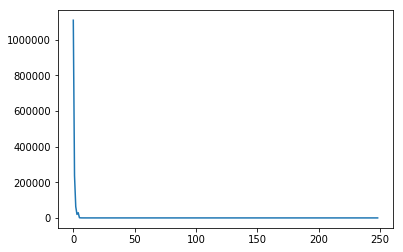

In [326]:
plt.plot(dist_X['dist_bin'], dist_X['distance_in_km'])

In [331]:
dist_X = dist_X[dist_X['dist_bin'] < 16]

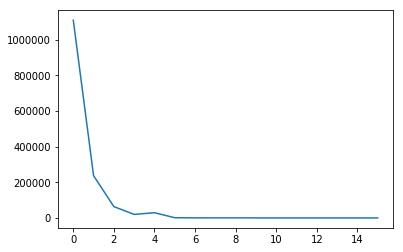

In [332]:
plt.plot(dist_X['dist_bin'], dist_X['distance_in_km'])

In [333]:
from sklearn.ensemble import ExtraTreesRegressor
extra_reg = ExtraTreesRegressor()
forest_clf_params

{'predictor__max_depth': [6, 8, 10],
 'predictor__n_estimators': [100, 200, 300],
 'predictor__min_samples_split': [1000, 10000]}

In [335]:
extra_reg_predictor = Pipeline([
    ('preparator' , preparatory_pipeline),
    ('scaler' , StandardScaler()),
    ('predictor', extra_reg )
])

In [336]:
extra_reg_grid_search = GridSearchCV( extra_reg_predictor , forest_clf_params, cv =2 , n_jobs=-1 , verbose = 2,
                                       scoring = 'neg_mean_squared_log_error')



In [337]:
extra_reg_grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=200 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=200 
[CV]  predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100, total= 2.8min
[CV]  predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=100, total= 2.8min
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=300 
[CV] predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=300 
[CV]  predictor__max_depth=6, predictor__min_samples_split=1000, predictor__n_estimators=200, total= 6.2min
[CV] predictor__max_depth=6, predictor__min_samples_split

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 72.5min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparator', FeatureUnion(n_jobs=1,
       transformer_list=[('num_pipeline', NumAttributePicker()), ('cat_pipeline', CatAttribPicker())],
       transformer_weights=None)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('predictor', ExtraTreesRegressor(bootstrap=Fal...stimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'predictor__max_depth': [6, 8, 10], 'predictor__n_estimators': [100, 200, 300], 'predictor__min_samples_split': [1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=2)

In [338]:
extra_reg_preds = extra_reg_grid_search.best_estimator_.predict(X_test)

In [339]:
extra_reg_grid_search.best_params_

{'predictor__max_depth': 10,
 'predictor__min_samples_split': 1000,
 'predictor__n_estimators': 200}

In [340]:
np.sqrt(mean_squared_log_error(y_test, extra_reg_preds))

0.6645413466087002

In [344]:
!pip3 install tensorflow

  Using cached tensorflow-2.1.0-cp36-cp36m-macosx_10_11_x86_64.whl (120.8 MB)
  Using cached protobuf-3.11.3-cp36-cp36m-macosx_10_9_x86_64.whl (1.3 MB)
Processing /Users/Kunal/Library/Caches/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe/gast-0.2.2-py3-none-any.whl
  Using cached opt_einsum-3.2.1-py3-none-any.whl (63 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
Processing /Users/Kunal/Library/Caches/pip/wheels/c3/af/84/3962a6af7b4ab336e951b7877dcfb758cf94548bb1771e0679/absl_py-0.9.0-py3-none-any.whl
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached tensorboard-2.1.1-py3-none-any.whl (3.8 MB)
  Using cached Keras_Preprocessing-1.1.0-py2.py3-none-any.whl (41 kB)
Processing /Users/Kunal/Library/Caches/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc/termcolor-1.1.0-py3-none-any.whl
Processing /Users/Kunal/Library/Caches/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63/wrapt-

In [345]:
!pip install --upgrade tensorflow==2.0.0-beta

     |████████████████████████████████| 87.9 MB 1.2 MB/s eta 0:00:01    |█▏                              | 3.1 MB 1.2 MB/s eta 0:01:11     |████████████████                | 44.1 MB 120 kB/s eta 0:06:03     |██████████████████████▌         | 61.7 MB 150 kB/s eta 0:02:55     |████████████████████████▏       | 66.4 MB 298 kB/s eta 0:01:12
     |████████████████████████████████| 496 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 136 kB/s eta 0:00:01
Processing /Users/Kunal/Library/Caches/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63/wrapt-1.12.1-cp36-cp36m-macosx_10_7_x86_64.whl
ERROR: tb-nightly 1.14.0a20190603 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.10.11
ERROR: Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a par

In [346]:
!pip3 install --upgrade wrapt

Processing /Users/Kunal/Library/Caches/pip/wheels/32/42/7f/23cae9ff6ef66798d00dc5d659088e57dbba01566f6c60db63/wrapt-1.12.1-cp36-cp36m-macosx_10_7_x86_64.whl
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.10.11
ERROR: Cannot uninstall 'wrapt'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
